In [177]:
%matplotlib inline

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from ase.cluster import Decahedron
from traitlets import link

from abtem import show_atoms
from abtem.transfer import CTF
from abtem.waves import PlaneWave
from abtem.measure import bandlimit
from abtem.visualize.interactive.artists import AtomsArtist, MeasurementArtist2d, MeasurementArtist1d
from abtem.visualize.interactive.canvas import Canvas
#from abtem.visualize.interactive.tools import SelectPositionTool, BoxZoomTool, PanZoomTool
from abtem.visualize.interactive.utils import throttle
from abtem.visualize.widgets import quick_sliders

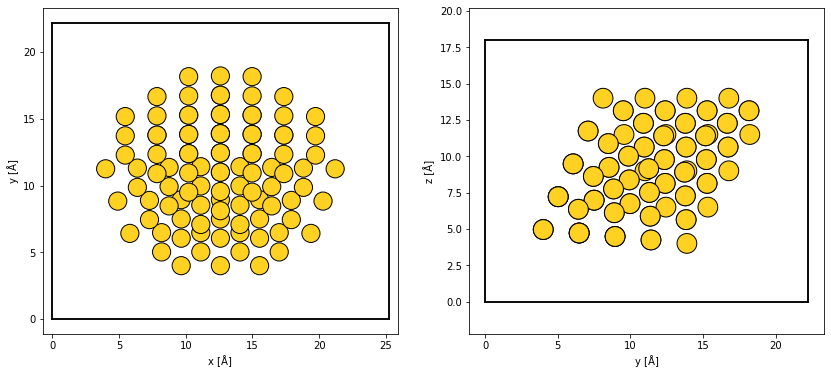

In [178]:
p = 3
q = 1
r = 1

atoms = Decahedron('Au', p, q, r, latticeconstant=None)
atoms.rotate(30, 'x', center='cop')

atoms.center(vacuum=4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
show_atoms(atoms, plane='xy', ax=ax1)
show_atoms(atoms, plane='yz', ax=ax2);

In [179]:
plane_wave = PlaneWave(sampling=0.1, energy=300e3)
exit_wave = plane_wave.multislice(atoms)
ctf = CTF(energy=300e3, rolloff=.05)

## Effect of limited dose

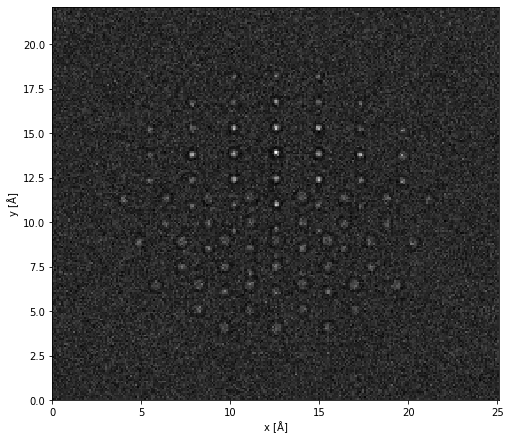

In [180]:
from abtem.noise import poisson_noise
eperA2 = 3
noisy = poisson_noise(ctf.apply(exit_wave).intensity(),10**eperA2,pixel_area 
                      = exit_wave._grid._sampling[0]*exit_wave._grid._sampling[1])

noisy.show(figsize=(8,8));

## Effect of distortions

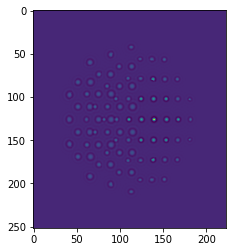

In [181]:
def apply_distortion_percentage(grid,P):
    mesh = np.meshgrid(*grid, indexing='ij')
    r = np.clip(np.hypot(*mesh),1e-6,None)
    if np.abs(P)<1e-3:
        return mesh
    F = P/(100-P)/np.amax(r)**2
    denom = 1-2*F*r**2-np.sqrt((2*F*r**2-1)**2-4*F**2*r**4)
    numer = 2*F**2*r**2
    return mesh/r*np.sqrt(denom/numer)

def fast_nearest_neighbour_interpolation(array,newgrid):

    s = array.shape
    p = np.prod(s)
    
    inds = np.reshape(np.round(newgrid).astype(np.int32),[2,p])
    
    # mask = np.logical_and(np.greater_equal(inds,0),np.less(inds,np.asarray(s).reshape((2,1))))
    # mask = np.logical_and(mask[0],mask[1])
    inds = np.ravel_multi_index(np.clip(inds,0,np.asarray(s).reshape((2,1))-1),s)
    arrayout = array.ravel()[inds]
    # ind = np.ravel_multi_index((inds[0][mask],inds[1][mask]), s,order='C')
    # arrayout = np.zeros(p)
    # arrayout[mask] = array.ravel()[ind]
    return arrayout.reshape(s)

def distort_array(array,percentage):

    s = array.shape
    grid = [np.fft.fftshift(np.fft.fftfreq(x))*x for x in s]
    xx,yy = apply_distortion_percentage(grid,percentage)
    
    return fast_nearest_neighbour_interpolation(array,np.stack([xx+s[0]//2,yy+s[1]//2],axis=0))

image = ctf.apply(exit_wave).intensity()
distorted = distort_array(ctf.apply(exit_wave).intensity().array[0], 10)

plt.imshow(distorted);

## Interactive example

In [182]:
throttling = 0.05
allow_drag = False

canvas1 = Canvas()

exit_wave_artist = MeasurementArtist2d()
atoms_artist = AtomsArtist(scale=0.5)

atoms_artist.atoms = atoms

canvas1.artists = {'image': exit_wave_artist, 'artist': atoms_artist}

canvas2 = Canvas(lock_scale=False, fig_margin={'top': 10, 'bottom': 40, 'left': 60, 'right': 10})
ctf_artist = MeasurementArtist1d()
envelope_artist = MeasurementArtist1d()
canvas2.artists = {'ctf': ctf_artist, 'envelope': envelope_artist}
canvas2.y_scale.min = -1 
canvas2.y_scale.max = 1 

canvas2.x_label = 'Spatial frequency [1/Å]'
canvas2.y_label = 'Contrast'

# position_tool = SelectPositionTool(marker=False, allow_drag=allow_drag)
# canvas1.tools = {'Position': position_tool}
# canvas2.tools = {'Zoom': BoxZoomTool(), 'Pan': PanZoomTool()}
# block_direct_button = widgets.ToggleButton(description='Block direct beam')
atoms_visible_button = widgets.ToggleButton(description='Overlay atoms')

link((atoms_artist, 'visible'), (atoms_visible_button, 'value'))

# eperA2 = 3
def update(*args):
    # Fetch value from slider
    eperA2 = dose_slider.value
    percentage = distort_slider.value
    ctf.defocus = defocus_slider.value
    ctf.Cs = Cs_slider.value
    ctf.gaussian_spread   = gaussian_spread_slider.value
    
    #abTEM calculation
    intensity = ctf.apply(exit_wave).intensity()
    intensity = poisson_noise(intensity, eperA2, pixel_area = 
                              exit_wave._grid._sampling[0]*exit_wave._grid._sampling[1])[0]
    intensity.array[:] = distort_array(intensity.array,percentage).reshape(intensity.array.shape)
        
    exit_wave_artist.measurement = intensity
    ctf_profiles = ctf.profiles(max_semiangle=100)
    
    # Set the objects to visualize
    ctf_artist.measurement = ctf_profiles['ctf']
    envelope_artist.measurement = ctf_profiles['envelope']

throttled_update = throttle(throttling)(update)

dose_slider = widgets.FloatLogSlider(description = 'e/$A^2$', value=1e4, base=10, min=0.0, max=6, step=.1)
defocus_slider = widgets.FloatSlider(description='Defocus', value=30, min=-100, max=100, step=1)
Cs_slider = widgets.FloatSlider(description='Cs', value=5e3, min=-1e5, max=1e5, step=1)
gaussian_spread_slider = widgets.FloatSlider(description='Spatial incoherence', 
                                             value=1.0, min=0.0, max=10.0, step=0.1)
distort_slider = widgets.FloatSlider(description = '% Pincushion/barrel distortion', min=-20, max=20, step=1)

dose_slider.observe(update, 'value')
defocus_slider.observe(update, 'value')
Cs_slider.observe(update, 'value')
gaussian_spread_slider.observe(update, 'value')
distort_slider.observe(update, 'value')

sliders = [dose_slider,defocus_slider,Cs_slider,gaussian_spread_slider, distort_slider]

# update(eperA2)
canvas1.adjust_limits_to_artists()
canvas1.adjust_labels_to_artists()
# canvas2.adjust_limits_to_artists()
# canvas2.adjust_labels_to_artists()

sliders[3].style = {'description_width': '125px'}
sliders[4].layout = {'width': '450px'}
sliders[4].style = {'description_width': '200px'}

In [174]:
update()
widgets.VBox([widgets.HBox([widgets.VBox([widgets.HBox([canvas1.figure, canvas2.figure]), 
                                          widgets.HBox([canvas1.toolbar, atoms_visible_button])]
                                         + sliders)])])